[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/docs/tutorials/nongaussian_errors.ipynb)
[![Open on Github](https://img.shields.io/badge/github-Open%20on%20Github-black?logo=github)](https://github.com/jfcrenshaw/pzflow/blob/main/docs/tutorials/nongaussian_errors.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [ ]:
# !pip install pzflow matplotlib

------------------
## Convolving non-Gaussian errors

This notebook demonstrates how to train a flow on data that has non-Gaussian errors/uncertainties, as well as convolving those errors in log_prob and posterior calculations.
We will use the example galaxy data again.

For an example of how to handle Gaussian errors, which is much easier, see the notebook on Gaussian errors.

In [5]:
import numpy as np
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

from pzflow import Flow
from pzflow.examples import get_galaxy_data

In [6]:
plt.rcParams["figure.facecolor"] = "white"

First let's load the example galaxy data set included with PZFlow, and include photometric errors. For simplicity, we will assume all bands have error = 0.1

In [7]:
data = get_galaxy_data()
for col in data.columns[1:]:
    data[f"{col}_err"] = 0.1 * np.ones(data.shape[0])
data.head()

,redshift,u,g,r,i,z,y,u_err,g_err,r_err,i_err,z_err,y_err
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623,0.1,0.1,0.1,0.1,0.1,0.1
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632,0.1,0.1,0.1,0.1,0.1,0.1
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112,0.1,0.1,0.1,0.1,0.1,0.1
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012,0.1,0.1,0.1,0.1,0.1,0.1
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056,0.1,0.1,0.1,0.1,0.1,0.1


Now, we need to build the machinery to handle non-Gaussian errors. PZFlow convolves errors by sampling from an error model, which by default is Gaussian. If we want to convolve non-Gaussian errors, we need to pass the `Flow` constructor an error model that tells it how to sample from our non-Gaussian distribution.

The error model must be a callable that takes the following arguments:
- key is a jax rng key, e.g. jax.random.PRNGKey(0)
- X is a 2 dimensional array of data variables, where the order of variables matches the order of the columns in data_columns
- Xerr is the corresponding 2 dimensional array of errors
- nsamples is the number of samples to draw from the error distribution

and it must return an array of samples with the shape `(X.shape[0], nsamples, X.shape[1])`

Below we build a photometric error model, which takes the exponential of the magnitudes to convert to flux values, adds Gaussian flux errors, then takes the log to convert back to magnitudes. 

In [9]:
def photometric_error_model(
    key,
    X: np.ndarray,
    Xerr: np.ndarray,
    nsamples: int,
) -> np.ndarray:
    
    # calculate fluxes
    F = 10 ** (X / -2.5)
    # calculate flux errors
    dF = np.log(10) / 2.5 * F * Xerr
    
    # add Gaussian errors
    eps = random.normal(key, shape=(F.shape[0], nsamples, F.shape[1]))
    F = F[:, None, :] + eps * dF[:, None, :]
    
    # add a flux floor to avoid infinite magnitudes
    # this flux corresponds to a max magnitude of 30
    F = np.clip(F, 1e-12, None)
    
    # calculate magnitudes
    M = -2.5 * np.log10(F)
    
    return M

Now we can construct the Flow, this time passing the error model

In [10]:
flow = Flow(
    ["redshift"] + list("ugrizy"), 
    data_error_model=photometric_error_model,
)

Now that we have set up the Flow with the new error model, we can train the flow, calculate posteriors, etc. just like we did in the Gaussian error example.

For example, to train with error convolution:

In [11]:
%%time
losses = flow.train(data, epochs=200, convolve_errs=True, verbose=True)

Training 200 epochs 
Loss:
(0) 20.3297
(1) 2.9366
(11) 0.1215
(21) -0.1496
(31) -0.0601
(41) -0.1246
(51) -0.2496
(61) -0.0759
(71) 0.1112
(81) -0.2375
(91) -0.2352
(101) -0.2811
(111) -0.2134
(121) -0.2033
(131) -0.2952
(141) -0.2706
(151) -0.2759
(161) -0.2222
(171) -0.1448
(181) -0.2966
(191) -0.1698
(200) -0.2314
CPU times: user 1h 8min 26s, sys: 45min 42s, total: 1h 54min 8s
Wall time: 22min 21s


And to calculate posteriors with error convolution:

In [12]:
grid = np.linspace(0, 3, 100)
pdfs = flow.posterior(data[:10], column="redshift", grid=grid, err_samples=int(1e3))

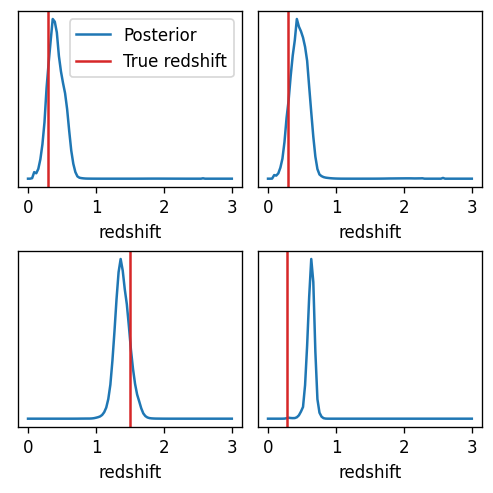

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=120, constrained_layout=True)

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(grid, pdfs[i], label="Posterior")
    ax.axvline(data["redshift"][i], c="C3", label="True redshift")
    ax.set(xlabel="redshift", yticks=[])

axes[0,0].legend()
plt.show()